In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
from astropy.cosmology import Planck18
import py21cmfast as p21c

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

We check that the environmental variables are set correctly.

In [ ]:
print('DM21CM_DIR:     ', os.environ['DM21CM_DIR'])
print('DM21CM_DATA_DIR:', os.environ['DM21CM_DATA_DIR'])
print('DH_DIR:         ', os.environ['DH_DIR'])
print('DH_DATA_DIR:    ', os.environ['DH_DATA_DIR'])
print('P21C_CACHE_DIR: ', os.environ['P21C_CACHE_DIR'])

## 1. Evolve `DM21cm`

We first specify parameters for `21cmFAST`, including simulation configuration and all astrophysical parameters.

In [ ]:
p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 64,
        BOX_LEN = 256, # [conformal Mpc]
        N_THREADS = 32,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        SIGMA_8 = Planck18.meta['sigma8'],
        hlittle = Planck18.h,
    ),
    random_seed = 12345,
    write = True,
)

p21c_astro_params = p21c.AstroParams(
    F_STAR10 = -1.25,
    F_STAR7_MINI = -2.5,
    ALPHA_STAR = 0.5,
    ALPHA_STAR_MINI = 0.0,
    t_STAR = 0.5,
    F_ESC10 = -1.35,
    F_ESC7_MINI = -1.35,
    ALPHA_ESC = -0.3,
    L_X = 40.5,
    L_X_MINI = 40.5,
    NU_X_THRESH = 500,
    A_LW = 2.0,
)

# optionally set global parameters
p21c.global_params.CLUMPING_FACTOR = 1.

Now we can start the `DM21cm` run. We recommend starting from a high redshift such as $z=45$. \
The default time step of `DM21cm` is $(z+\Delta z)/z=1.002$. \
We recommend a coarser time step for `21cmFAST` $(z+\Delta z)/z=1.002^{10}\approx1.02$. \
This can be achieved by setting `subcycling_factor=10`, which is the default value. \
Set `dm_params`, and we are ready to go.

In [ ]:
return_dict = evolve(
    run_name = 'test',
    z_start = 45.,
    z_end = 5.,
    subcycle_factor = 10,
    dm_params = DMParams(
        mode='decay',
        primary='phot_delta',
        m_DM=1e8, # [eV]
        lifetime=1e28, # [s]
    ),
    p21c_initial_conditions = p21c_initial_conditions,
    p21c_astro_params = p21c_astro_params,
)

you should see outputs that looks like this:
```
[YYYY-MM-DD HH:MM:SS,XXX] INFO: dm21cm.evolve: Using 21cmFAST version X.X.X
[YYYY-MM-DD HH:MM:SS,XXX] INFO: dm21cm.evolve: Cache dir: /path/to/cache_dir/test
[YYYY-MM-DD HH:MM:SS,XXX] INFO: dm21cm.TransferFunctionWrapper: Loaded photon transfer functions.
[YYYY-MM-DD HH:MM:SS,XXX] INFO: dm21cm.TransferFunctionWrapper: Skipping electron transfer functions.
[YYYY-MM-DD HH:MM:SS,XXX] INFO: dm21cm.DarkHistoryWrapper: Running DarkHistory to generate initial conditions...
[YYYY-MM-DD HH:MM:SS,XXX] INFO: darkhistory.config: Using data at /path/to/DHdata_v1_1
[YYYY-MM-DD HH:MM:SS,XXX] INFO: darkhistory.config: Loaded deposition transfer functions.
[YYYY-MM-DD HH:MM:SS,XXX] INFO: darkhistory.config: Loaded ICS transfer functions.
100%|██████████| 431/431 [00:45<00:00,  9.50it/s]
[YYYY-MM-DD HH:MM:SS,XXX] INFO: dm21cm.DarkHistoryWrapper: Saved DarkHistory initial conditions.
100%|██████████| 1010/1010 [23:49<00:00,  1.42s/it]
xray        : 0.6174 +/- 0.1840 s * 1009 steps : 622.9507 s
bath+dm     : 0.0337 +/- 0.0007 s * 1009 steps : 34.0274 s
prep next   : 0.0189 +/- 0.0027 s * 1009 steps : 19.0329 s
21cmFAST    : 7.4479 +/- 2.2558 s * 100 steps : 744.7943 s
lightcone   : 6.9483 s * 1 steps : 6.9483 s
```

In the `cache_dir` directory, you will find the following files from `21cmFAST`: \
`IonizedBox_[hash]_r[seed].h5` \
`TsBox_[hash]_r[seed].h5` \
`BrightnessTemp_[hash]_r[seed].h5` \
`PerturbedField_[hash]_r[seed].h5` \
Aside from these, there will be files generated by `DM21cm`:

In [ ]:
[f for f in os.listdir(f"{os.environ['P21C_CACHE_DIR']}/test") if f[:6] not in ['Initia', 'Ionize', 'TsBox_', 'Pertur', 'Bright']]

['global_records.npy',
 'dh_init_soln.p',
 'xray_cache_snapshot.p',
 'lc_test.h5',
 'xray_box_cache.h5']

`global_records.npy` : contains the same information as return_dict['global']. \
`lightcones.h5` : contains the same information as return_dict['lightcone']. \
`xray_box_cache.h5`: contains the cached xray relative luminosities due to DM injection. \
`xray_cache_snapshot.p`: contains a snapshot of the `XrayCacher` object (that controls `xray_box_cache.h5`). Used for resuming runs. \
`dh_init_soln.p`: contains `DarkHistory` solutions up to $\lesssim45$ for initialization of `DM21cm`.

## 2. Viewing results
The returned dictionary contains keys `global`, `lightcone`, and `profiler`. We first look at some global quantities.

### 2.1 Global quantities

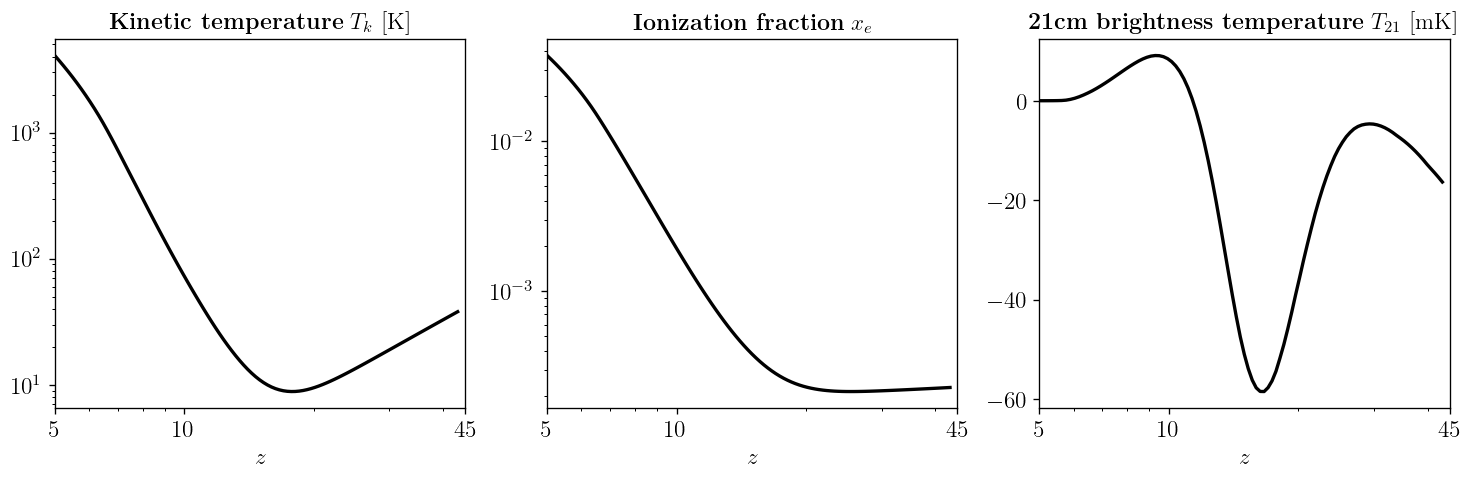

In [ ]:
rec = return_dict['global']

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

def format_xaxis(ax):
    ax.set(xlim=(5, 45), xscale='log')
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set(xticks=[5, 10, 45], xticklabels=['5', '10', '45'])

ax = axs[0]
ax.plot(rec['z'], rec['T_k'], color='k', lw=2)
ax.set(yscale='log')
format_xaxis(ax)
ax.set(xlabel=r'$z$', title=r'\textbf{Kinetic temperature} $T_k$ [K]')

ax = axs[1]
ax.plot(rec['z'], rec['x_e'], color='k', lw=2)
ax.set(yscale='log')
format_xaxis(ax)
ax.set(xlabel=r'$z$', title=r'\textbf{Ionization fraction} $x_e$')

ax = axs[2]
ax.plot(rec['z'], rec['T_b'], color='k', lw=2)
format_xaxis(ax)
ax.set(xlabel=r'$z$', title=r'\textbf{21cm brightness temperature} $T_{21}$ [mK]');

### 2.2 Lightcone quantities

In [ ]:
lc = return_dict['lightcone']

In [ ]:
lc.lightcones['brightness_temp']

dict_keys(['brightness_temp', 'Ts_box', 'Tk_box', 'x_e_box', 'xH_box', 'density'])

In [ ]:
EoR_color = mpl.colors.LinearSegmentedColormap.from_list('EoR', [
    (0.0,  'yellow'),
    (0.25, 'orange'),
    (0.5,  'red'),
    (0.75, 'black'),
    (0.85, 'blue'),
    (0.95, 'cyan'),
    (1.0,  'cyan')
])
vmin, vmax = -60, 20 # 0 at 0.75

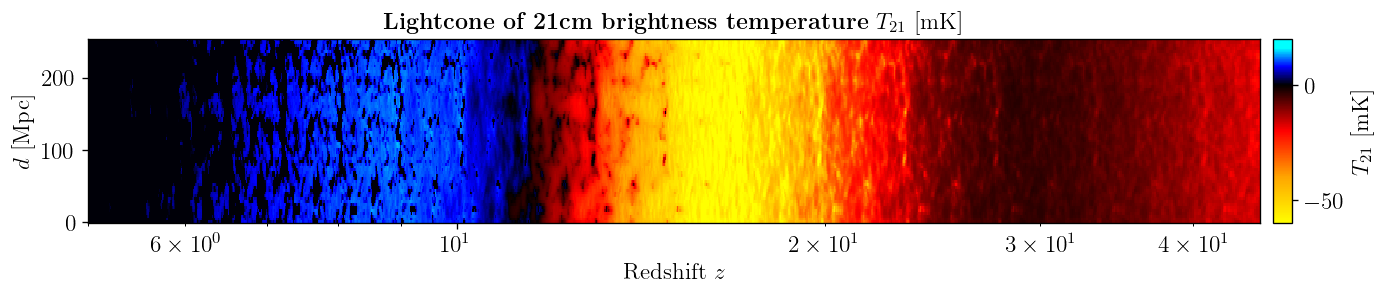

In [ ]:
fig, axs = plt.subplots(figsize=(15, 2))

ax = axs
im = ax.pcolormesh(
    lc.lightcone_redshifts,
    np.arange(64) * 4,
    lc.lightcones['brightness_temp'][:,0,:],
    cmap=EoR_color, vmin=vmin, vmax=vmax
)
ax.set(xscale='log')
ax.set(xlabel=r'Redshift $z$', ylabel=r'$d$ [Mpc]', title=r'\textbf{Lightcone of 21cm brightness temperature} $T_{21}$ [mK]')
cbar = fig.colorbar(im, ax=ax, aspect=10, pad=0.01)
cbar.set_label(r'$T_{21}$ [mK]')

### 2.3 Compute time information

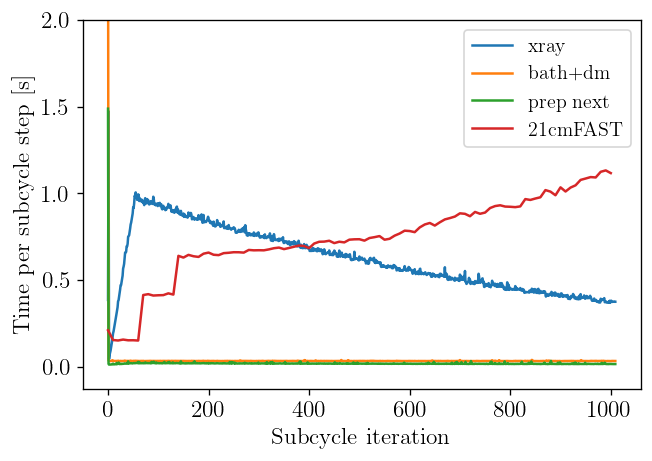

In [ ]:
profiler = return_dict['profiler']

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
profiler.plot(ax=axs)
axs.set(ylim=(None, 2.0));